У нас есть данные АА-теста с '2023-06-23' по '2023-06-29'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.у нас есть данные АА-теста с '2023-06-23' по '2023-06-29'.

In [2]:
# Импортируем необходимые библиотеки

import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [3]:
# Подключаемся к БД

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [5]:
# Делаем запрос необходимых данных для проведения АА-теста
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-23' and '2023-06-29'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

# Сгруппируем данные, чтобы узнать количество пользователей в каждой группе 
df.groupby('exp_group').user_id.count()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

Видим, что количество пользователей примерно одинаковое

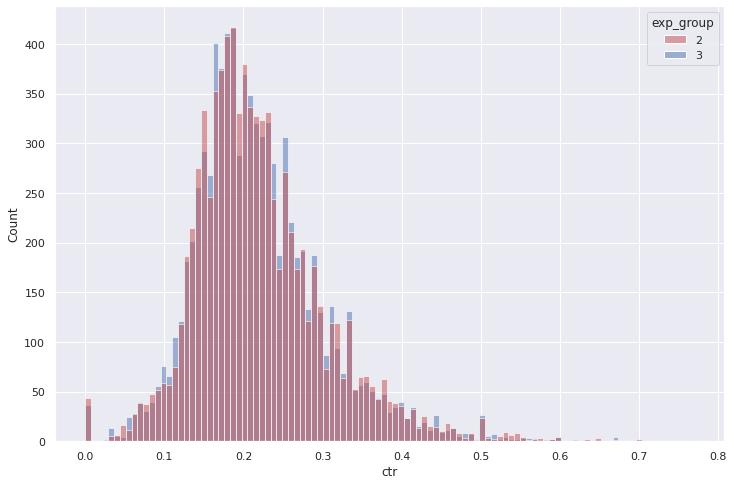

In [9]:
# Строим график исходных данных
sns.set(rc={'figure.figsize':(12, 8)})
groups = sns.histplot(data = df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Мы видим, что данные распределены примерно одинаково

In [11]:
# Генерируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы и проводим t-тесты

group2 = df[df.exp_group == 2]
group3 = df[df.exp_group == 3]

p_values = []
for _ in range(10000):
    gr_2 = group2.ctr.sample(500, replace = False)
    gr_3 = group2.ctr.sample(500, replace = False)
    p_value = stats.ttest_ind(gr_2, gr_3, equal_var=False)[1]
    p_values.append(p_value)
p_values = pd.Series(p_values)

<AxesSubplot:ylabel='Count'>

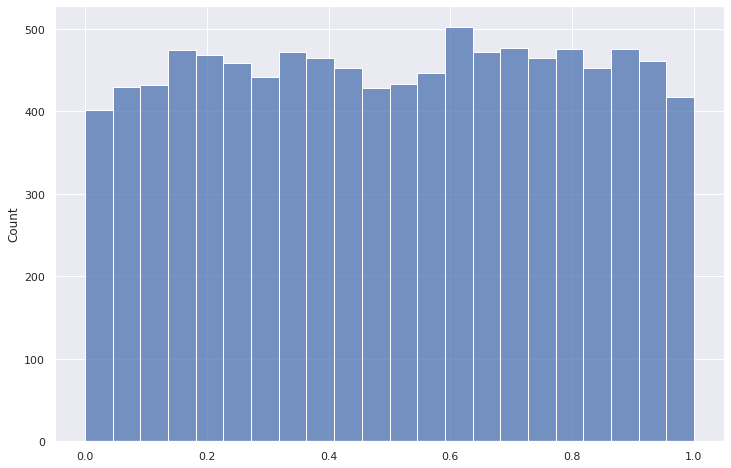

In [15]:
# Построим гистограмму распределения получившихся 10000 p-values
sns.histplot(p_values)

p-values распределены примерно равномерно

In [20]:
# Найдем какой процент p-values оказался меньше либо равен 0.05
count = 0
for p_value in p_values:
    if p_value <= 0.05:
        count += 1
percent = (count / len(p_values)) * 100
percent

4.45

Вывод: Распределение p-values равномерное. 
P-values оказалось менее, чем в 5% случаев меньше или равен 0.05. 
Это означает, что система сплитования работает корректно, и AA-тест проведен успешно.